I will attempt time-series analysis on corn prices using an ARIMA model in order to forecast prices at intervals of 1, 3, 6, 9, and 12 months into the future.

First I need to load the packages and set the formatting.

In [1]:
# Load imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set global style
sns.set_theme()
rcParams['figure.figsize'] = 15, 8
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13

Next I can examine the data. There are some NaN variables for future dates that do not yet have a spot price, so I will need to drop them before performing any analysis. The value column is listed in dollars per bushel (USD).

In [3]:
corn_hist_price = pd.read_csv('corn-prices-historical-chart-data.csv')
corn_hist_price.columns = corn_hist_price.columns.str.strip()
corn_hist_price['date'] = pd.to_datetime(corn_hist_price['date'])
corn_hist_price.set_index('date', inplace=True)
corn_hist_price

,value
date,
1959-07-01,1.177
1959-07-02,1.176
1959-07-06,1.171
1959-07-07,1.171
1959-07-08,1.170
...,...
2024-08-10,NaN
2024-08-11,NaN
2024-08-12,NaN


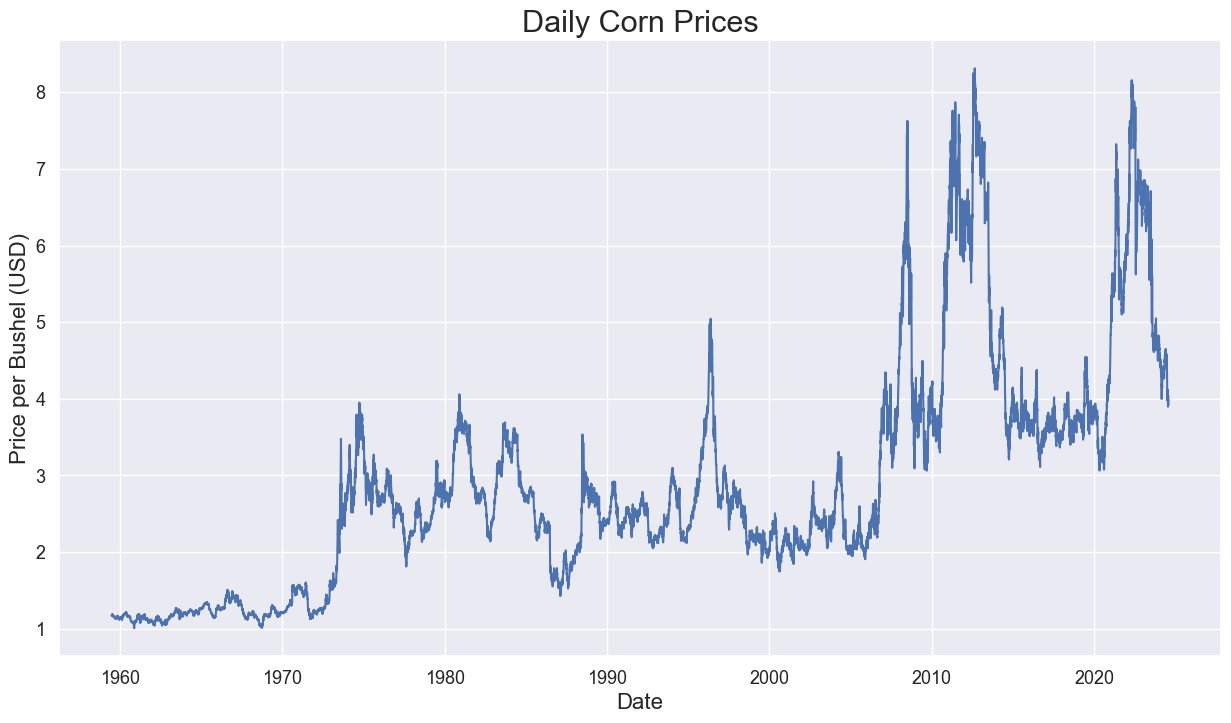

In [4]:
fig,ax = plt.subplots()

# plot Jacksonville data
ax.plot(corn_hist_price)

ax.set_title('Daily Corn Prices')
ax.set_ylabel('Price per Bushel (USD)')
ax.set_xlabel('Date')
plt.show()

We can see the historical daily price plotted above, but the increased volatility from daily data points will likely introduce some noise into the model, so I will plot the monthly averages below as well:

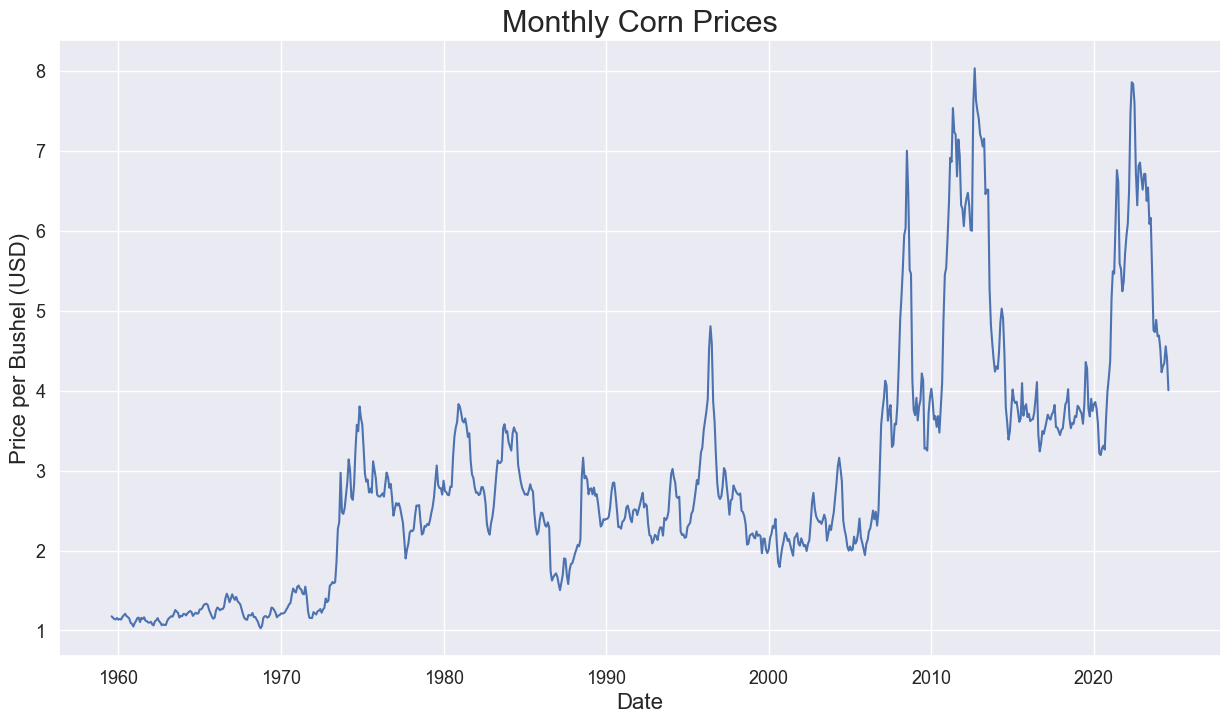

In [5]:
# Calculate the monthly averages
monthly_avg = corn_hist_price.resample('ME').mean()
fig,ax = plt.subplots()

ax.plot(monthly_avg)
ax.set_title('Monthly Corn Prices')
ax.set_ylabel('Price per Bushel (USD)')
ax.set_xlabel('Date')
plt.show()

This will likely be much more useful for the ARIMA models, so I will use this monthly average dataset moving forward. Now that I have the data ready, I will perform an ADF test (also known as the Dickey-Fuller test) to see if the data is stationary. If the data is not stationary, it is typically not suitable for use in an ARIMA model. Below is a function to perform the ADF test.

In [6]:
def dickey_fuller(ts, prnt=True):
    '''
    Create a dataframe with the results of the Dickey-Fuller Test.
    ---
    Input:
    
    ts: time series to be evaluated
    prnt: print results if True, else returns the p-value
    '''
    # perform dickey-fuller test
    dickey = adfuller(ts)
    
    if prnt:
        results = pd.Series(dickey[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
        for key,value in dickey[4].items():
            results['Critical Value (%s)'%key] = value
            
        print('Results of Dickey-Fuller Test: \n')
        print(results)
        
    else:
        # p-value
        return dickey[1]

In [7]:
# test stationarity of the time series
dickey_fuller(monthly_avg.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                  -2.521294
p-value                          0.110379
#Lags Used                      15.000000
Number of Observations Used    765.000000
Critical Value (1%)             -3.438927
Critical Value (5%)             -2.865325
Critical Value (10%)            -2.568786
dtype: float64


The key value here is the p-value, which tests the null hypothesis that the data is non-stationary. Typically a threshhold of 0.05 is used to determine if the null hypothesis can be rejected. A value below 0.05 means that there is less than a 5% probability that the observed difference between the hypothesis and outcome were due to pure chance. With a p-value above of 0.11, we cannot be confident enough to reject the null hypothesis, which in this context means that are data is non-stationary.

This is not a huge surprise, and can be infered by looking at the plot of historical prices, but it is important to confirm regardless. One way to try make the data stationary is removing seasonality. In this case, it is likely that corn prices have strong yearly seasonality based around the growing season, meaning that the price predictably fluctuates over the course of a year. To remove the seasonality, I will take the difference of each month's price with the price from one year prior. I will then perform another ADF test and plot the new dataset.

In [8]:
non_seasonal = monthly_avg.diff(periods=12)

dickey_fuller(non_seasonal.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                -7.517345e+00
p-value                        3.871821e-11
#Lags Used                     1.900000e+01
Number of Observations Used    7.490000e+02
Critical Value (1%)           -3.439111e+00
Critical Value (5%)           -2.865407e+00
Critical Value (10%)          -2.568829e+00
dtype: float64


The p-value has decreased dramatically, well below the typical threshold, and suggests that the new data is stationary. Let's see what it looks like plotted out:

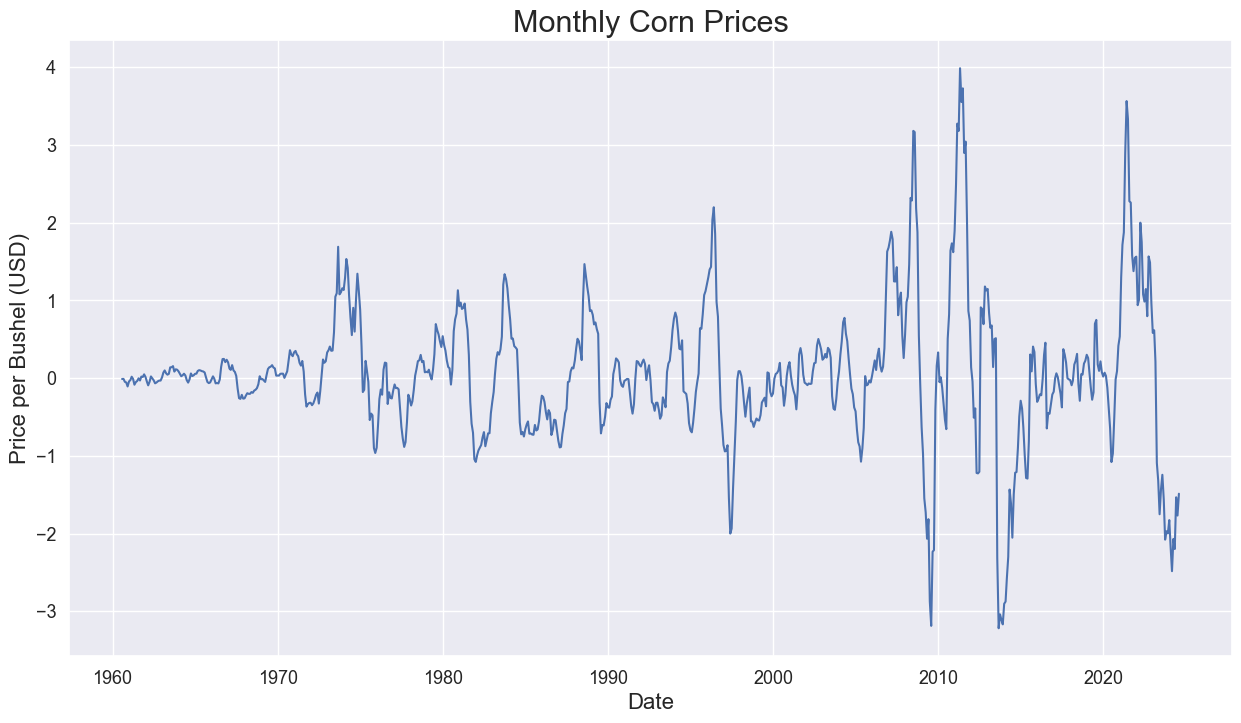

In [9]:
fig,ax = plt.subplots()

ax.plot(non_seasonal)
ax.set_title('Monthly Corn Prices')
ax.set_ylabel('Price per Bushel (USD)')
ax.set_xlabel('Date')
plt.show()

We see the price does indeed remain stationary over time, but there is another visible issue: heteroscedasticity. This means that the variance of the data (the volatility in price change), increases over time. Ideally, we would want the heteroscedasticity to remain consistent as well.

In order to try and reduce the heteroscedasticity, I will also test two alternative datasets. First, I will take the first-order (FO) difference between each month's average price. This means that instead of differencing the price from the same month of the previous year, I will use the difference between the current month and previous month, since there is a chance that the monthly prices highly corrolate with the previous month's price.

Secondly, I will test a dataset that uses both the first-order difference as well as the yearly difference.

In [10]:
FO = monthly_avg.diff()
dickey_fuller(FO.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                -7.292644e+00
p-value                        1.404118e-10
#Lags Used                     1.400000e+01
Number of Observations Used    7.650000e+02
Critical Value (1%)           -3.438927e+00
Critical Value (5%)           -2.865325e+00
Critical Value (10%)          -2.568786e+00
dtype: float64


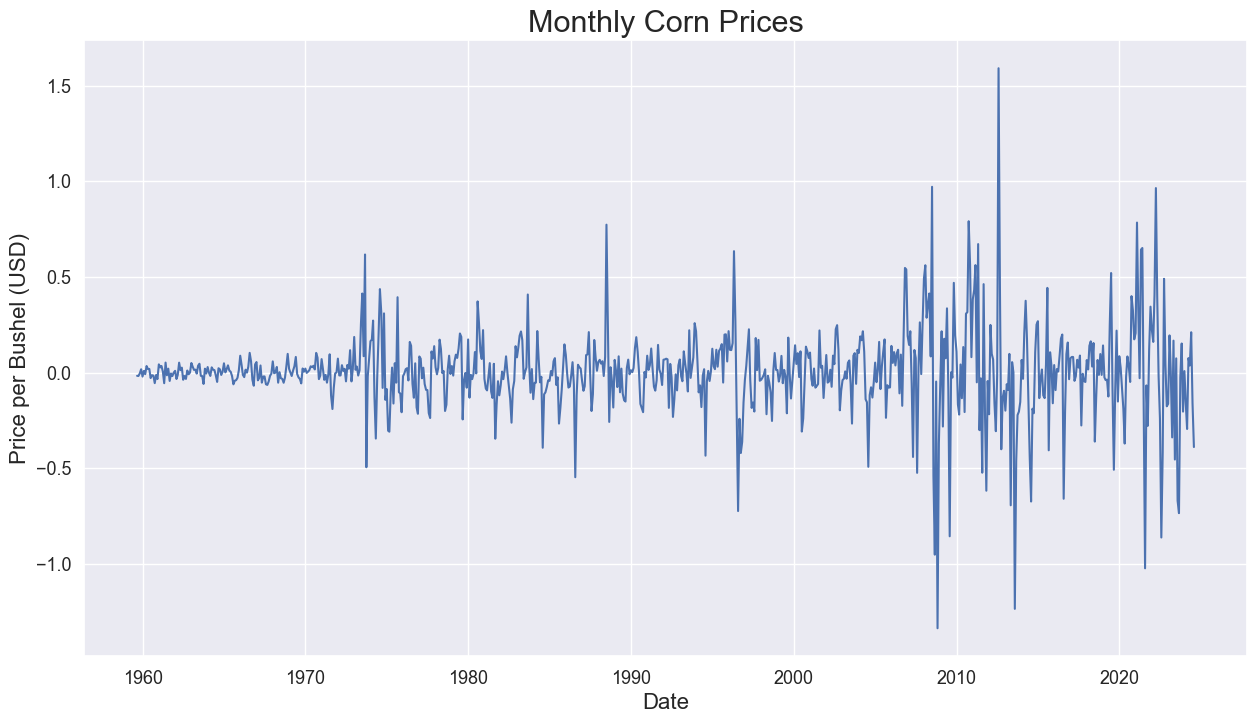

In [11]:
fig,ax = plt.subplots()

ax.plot(FO)
ax.set_title('Monthly Corn Prices')
ax.set_ylabel('Price per Bushel (USD)')
ax.set_xlabel('Date')
plt.show()

Above we see the results of first-order differenced data. Though the p-value is technically larger the the yearly differenced data, it is still so small that we can be confident in its stationarity. Additionally, the variance seems to have been reduced, although there is still evidence of heteroscedasticity. Next I will test the yearly, first-order differenced data:

In [12]:
FO_non_seasonal = non_seasonal.diff()

dickey_fuller(FO_non_seasonal.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                -7.230788e+00
p-value                        1.997227e-10
#Lags Used                     2.000000e+01
Number of Observations Used    7.470000e+02
Critical Value (1%)           -3.439134e+00
Critical Value (5%)           -2.865417e+00
Critical Value (10%)          -2.568834e+00
dtype: float64


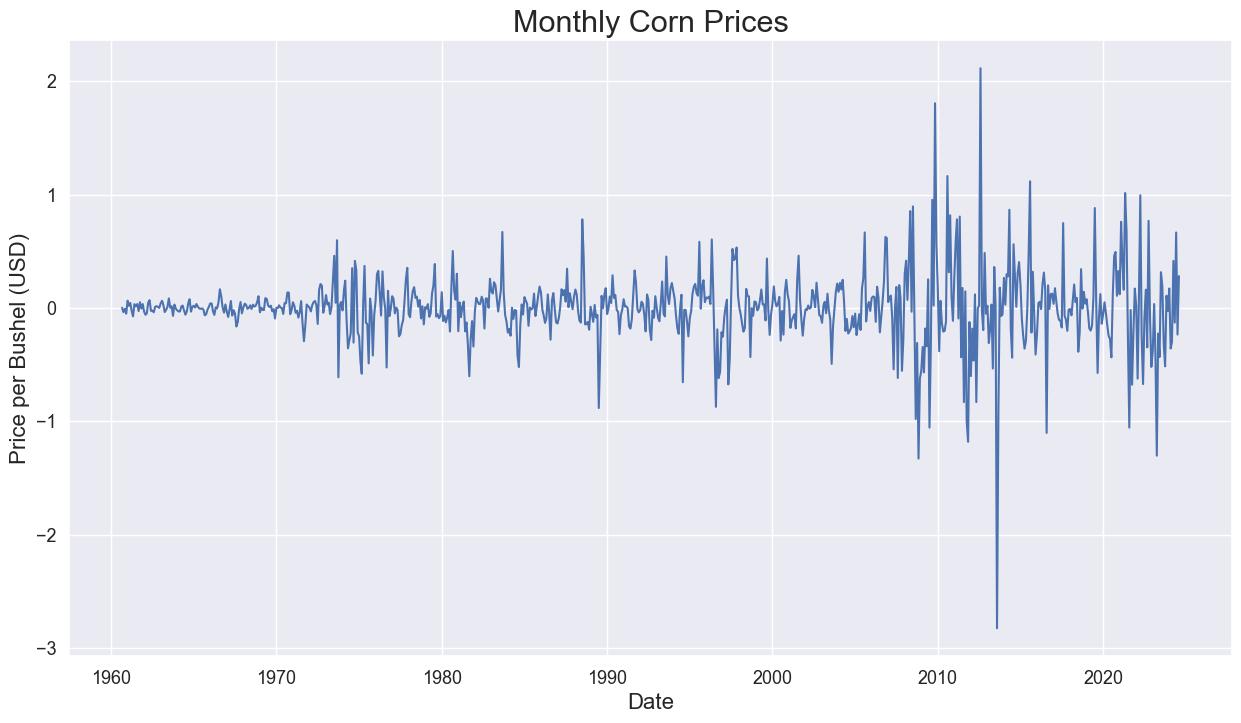

In [13]:
fig,ax = plt.subplots()

ax.plot(FO_non_seasonal)
ax.set_title('Monthly Corn Prices')
ax.set_ylabel('Price per Bushel (USD)')
ax.set_xlabel('Date')
plt.show()

The p-value remains low, but there is still the issue of heteroscedasticity. Since it is unclear which dataset will provide the best training for an ARIMA model, and testing each by hand will be extremely cumbersome, I will use `auto_arima` to test a large number of model hyperparameters to determine what amount of AR (auto-regressive), MA (moving-average), and differencing leads to the best model.

Additionally, I need to split the training and test data. In order to limit the effects of things like inflation, and ensure that the model is relevant and reflective of the current market, I will only use data beginning from the year 2000, as seen below:

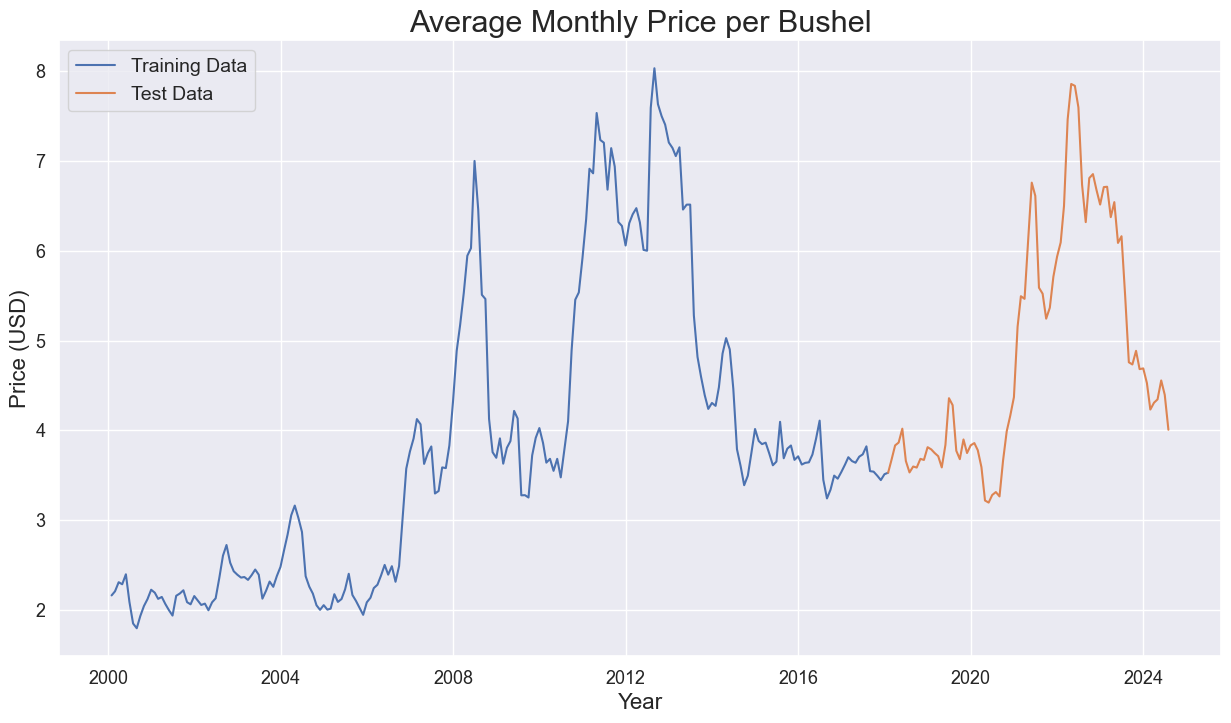

In [14]:
monthly_avg = monthly_avg.dropna()

start_date = '2000-01-31'
cutoff_date = '2018-01-31'
end_date = '2024-07-31'

X = monthly_avg[start_date:]

# set train-test split
train = X[:cutoff_date]
test = X[cutoff_date:]

fig,ax = plt.subplots()

ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')

ax.set_title('Average Monthly Price per Bushel')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Year')
plt.legend(fontsize=14)
plt.show()

Next I will use `auto_arima` to determine the optimal hyper-parameters by comparing AIC scores:

In [15]:
model = auto_arima(train,
                   test='adf', # dickey-fuller
                   m=12, # yearly seasonality
                   d=None, # set to None to find the best order of differencing
                   seasonal=True,
                   stepwise=True,
                   with_intercept=False
                  )

print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  217
Model:             SARIMAX(1, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood                 -40.149
Date:                                 Fri, 26 Jul 2024   AIC                             88.298
Time:                                         14:41:25   BIC                            101.800
Sample:                                     01-31-2000   HQIC                            93.753
                                          - 01-31-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2456      0.062      3.950      0.000       0.124       0

The results indicate that a SARIMAX(1,1,0)(0,0,[1,2],12) model is the most performant. The test results toward the bottom indicate some heteroscedasticity and kurtosis, as expected, and the high Jarque-Bera score suggests that the data is non-normal. This is a potential issue that should be addressed moving forward, but since this is the best model tested I will use it for the time being.

Below I will train the model and examine the diagnostics:

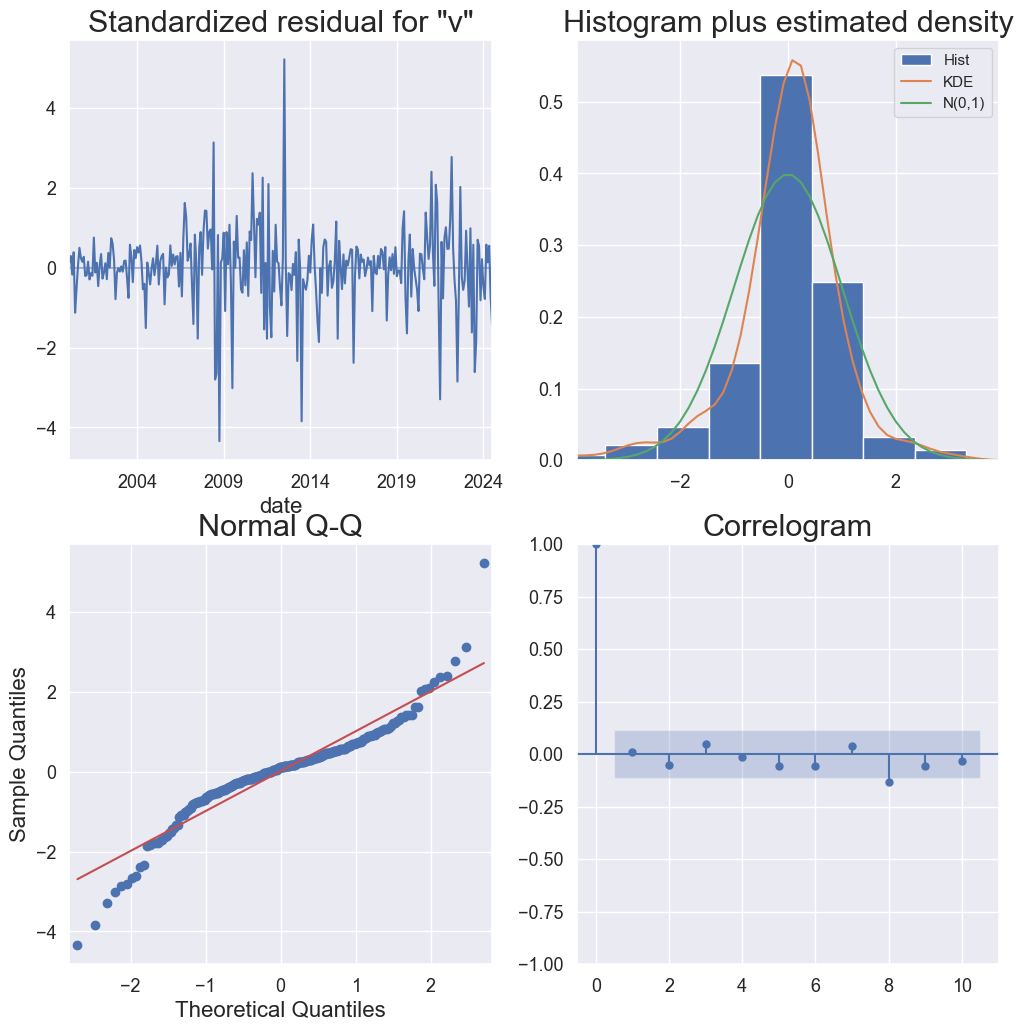

In [16]:
SARIMAX_MODEL = SARIMAX(X,
                    order=(1,1,0),
                    seasonal_order=(0,0,[1,2],12),)

output = SARIMAX_MODEL.fit()
output.plot_diagnostics(figsize=(12, 12));

The Normal Q-Q graph does suggest non-normality, but the other indicators look good.

Now I want to calculate the model error for 1, 3, 6, 9, and 12-month forecasts. This will entail refitting the model with each new data point from the test data to get up-to-date predictions:

In [17]:
# Create a DataFrame to store the forecasts
forecasts = pd.DataFrame(index=test.index)

# Loop through each month in the test data
for i in range(len(test)):
    current_train = pd.concat([train, test[:i+1]])  # Update the training data to include new test data
    
    # Refit the SARIMAX model with the updated training data
    SARIMAX_MODEL = SARIMAX(current_train,
                            order=(1,1,0),
                            seasonal_order=(0,0,[1,2],12),)
    
    output = SARIMAX_MODEL.fit(disp=False)  # Suppress fit summary output for brevity
    
    # Generate forecasts for 1, 3, 6, 9, and 12 months ahead
    forecast_steps = [1, 3, 6, 9, 12]
    for step in forecast_steps:
        if i + step < len(test):
            forecast = output.get_forecast(steps=step)
            pred_mean = forecast.predicted_mean.iloc[-1]  # Get the last forecasted value for the given step
            forecasts.loc[test.index[i], f'forecast_{step}'] = pred_mean

# Drop rows with NaN values (initial rows where forecasts are not possible)
forecasts.dropna(inplace=True)

print(forecasts)

            forecast_1  forecast_3  forecast_6  forecast_9  forecast_12
date                                                                   
2018-01-31    3.527573    3.499516    3.643912    3.632704     3.585736
2018-02-28    3.699708    3.661876    3.820189    3.791558     3.753008
2018-03-31    3.847076    3.915029    3.979376    3.959000     3.906837
2018-04-30    3.854325    4.025343    4.014681    3.967894     3.912049
2018-05-31    4.140044    4.232816    4.205238    4.166691     4.098195
...                ...         ...         ...         ...          ...
2023-03-31    6.215545    6.170226    6.373643    6.333829     6.201298
2023-04-30    6.565304    6.803113    6.800810    6.742011     6.613110
2023-05-31    6.011390    6.214537    6.138842    6.039505     5.969810
2023-06-30    6.362783    6.388780    6.343466    6.200913     6.192200
2023-07-31    5.313819    5.195443    5.151278    5.061753     5.213350

[67 rows x 5 columns]


Now that I have all the predictions, I can compare them to the actual prices to determine the amount of error present in the model:

In [18]:
# Create a DataFrame to store the actual values for comparison
actuals = pd.DataFrame(index=test.index)

# Loop through the test data to get actual values for each forecast step
for step in forecast_steps:
    actuals[f'actual_{step}'] = test.shift(-step)

# Drop rows with NaN values (initial and final rows where actuals are not available)
actuals.dropna(inplace=True)

# Calculate error metrics for each forecast step
for step in forecast_steps:
    mae = mean_absolute_error(actuals[f'actual_{step}'], forecasts[f'forecast_{step}'])
    mse = mean_squared_error(actuals[f'actual_{step}'], forecasts[f'forecast_{step}'])
    rmse = np.sqrt(mse)
    print(f'Step {step} months ahead: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}')

Step 1 months ahead: MAE = 0.2529, MSE = 0.1187, RMSE = 0.3446
Step 3 months ahead: MAE = 0.5918, MSE = 0.5956, RMSE = 0.7718
Step 6 months ahead: MAE = 0.8450, MSE = 1.2626, RMSE = 1.1236
Step 9 months ahead: MAE = 0.9657, MSE = 1.7176, RMSE = 1.3106
Step 12 months ahead: MAE = 1.1472, MSE = 2.0002, RMSE = 1.4143


The root-mean squared error is in real dollars, meaning that the average error for 1 month predictions was .34 cents, and the average error for 12-month predictions was $1.41.

Overall, the error is likely too large for the model to be useful in predicting corn futures, but given that this is a preliminary model, I think the results are promising. There are several more adjustments that could be made, such as factoring in supply-demand price predictions provided by the USDA in their regular WASDE reports. Additionally, there were several periods of high volatility in the data, for example during the COVID pandemic. These large-scale events are certainly going to affect prices, so adding variables to the mathematical models that can account for such factors would also likely improve the model accuracy.